## 分析A/B测试结果

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

对于这个项目，将要了解的是电子商务网站运行的 A/B 测试的结果。目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
#### I - 概率

先导入库

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape

(294478, 5)

c. 数据集中独立用户的数量。

In [4]:
df.user_id.nunique()

290584

d. 用户转化的比例。

In [5]:
df.query('converted==1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
df.query('group == "treatment"and landing_page != "new_page"').shape[0]+df.query('group != "treatment"and landing_page == "new_page"').shape[0]

3893


f. 是否有任何行存在缺失值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。 

In [8]:
df_treatment = df.query("group == 'treatment'and landing_page == 'new_page'")

In [9]:
df_control = df.query("group == 'control' and landing_page == 'old_page'")

In [10]:
df2 = df_treatment.append(df_control)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

查看**df2** 中有多少唯一的 **user_id**?

In [13]:
df2.user_id.nunique()

290584

打印出**df2** 中的一个重复的 **user_id**

In [14]:
df2.user_id[df2.duplicated('user_id')==True]

2893    773192
Name: user_id, dtype: int64

这个重复的  **user_id** 的行信息

In [15]:
df2[df2.duplicated('user_id')==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


删除 **一个** 含有重复的 **user_id** 的行

In [16]:
df2 = df2.drop_duplicates('user_id')


a. 不管它们收到什么页面，单个用户的转化率是多少？


In [17]:
df2.converted.mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [18]:
df_control_ctr = df2.query("group=='control'").converted.mean()
df_control_ctr

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [19]:
df_treatment_ctr = df2.query("group=='treatment'").converted.mean()
df_treatment_ctr

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [20]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

In [21]:
diff_ctr = df_treatment_ctr - df_control_ctr
diff_ctr

-0.0015782389853555567

答案：根据之前得到的数据看来，用户收到control页面的转化率比treatment页面的转化率高0.0015，这个数值比较小，我认为还没有特别的证据表明哪一个页面可以带来更多的转化，需要借助后续的分析。

<a id='ab_test'></a>
### II - A/B 测试

由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？


`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

**在这里给出你的答案。**

零假设：**$p_{old}$** >= **$p_{new}$**

备择假设：**$p_{old}$** < **$p_{new}$**

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [22]:
new_df = df.query("landing_page=='new_page'")
new_ctr = new_df.query('converted==1').user_id.nunique()/new_df.user_id.nunique()
new_ctr

0.11952131331287547

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [23]:
old_ctr = new_ctr
old_ctr

0.11952131331287547

c.  $n_{new}$ 是多少？

In [24]:
#运用之前处理过的数据，去除ab_data.csv数据集中control组不是old_page，treatment组不是new_page的数据。以为不准确的数据会对结果造成误导
new_df = df_treatment.append(df_control)

In [25]:
new_df = new_df.drop_duplicates('user_id')

In [26]:
n_new = new_df.query('landing_page=="new_page"').user_id.nunique()
n_new

145310

d.  $n_{old}$?是多少？

In [27]:
n_old = new_df.query('landing_page=="old_page"').user_id.nunique()
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [28]:
new_page_converted = np.random.choice([0,1],size=n_new,p=[0.88,0.12])

In [29]:
new_page_converted.sum()

17481

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [30]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[0.88,0.12])

In [31]:
old_page_converted.sum()

17290

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [32]:
test_p_new = new_page_converted.sum()/n_new
test_p_old = old_page_converted.sum()/n_old

In [33]:
p_diff = test_p_new - test_p_old

In [34]:
p_diff

0.0012849453358242807

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [35]:
p_diffs = []
for _ in range(10000):
    p_new = (np.random.choice([0,1] ,size = n_new,p = [1-new_ctr,new_ctr])).mean()
    p_old = (np.random.choice([0,1] ,size = n_old,p = [1-old_ctr,old_ctr])).mean()
    p_diffs.append(p_new - p_old)

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？

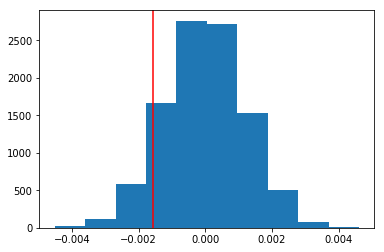

In [36]:
plt.hist(p_diffs);
plt.axvline(x=diff_ctr,color='r')

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [37]:
(p_diffs > diff_ctr).mean()

0.905

我的答案：得出的值是我们假设零假设为真时，在抽样分布均差中的出的结果，大于在ab_data.csv数据集中观察到的实际差值的概率。在科学研究中我们称这个值为P值。P值的结果是0.905，大于5%，因此我们不拒绝零假设。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [39]:
import statsmodels.api as sm

convert_old = (new_df.query('landing_page=="old_page"')['converted']==1).sum()
convert_new = (new_df.query('landing_page=="new_page"')['converted']==1).sum()
n_old = new_df.query('landing_page=="old_page"').user_id.nunique()
n_new = new_df.query('landing_page=="new_page"').user_id.nunique()

In [40]:
print(convert_old,convert_new,n_old,n_new )

17489 17264 145274 145310


m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [67]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')

In [68]:
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [69]:
from scipy.stats import norm

norm.cdf(z_score)

0.9050583127590245

In [70]:
norm.ppf(1-0.05)

1.6448536269514722

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？


我们得到的z值1.3109241984234394小于临界值1.6448536269514722，所以我们接受零假设。即认为新旧页面的转化率没有区别。得到的结果与j.k.中的结果一致。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行逻辑回归


b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [45]:
df3 = new_df
df3['intercept'] = 1
df3[['A','ab_page']] = pd.get_dummies(df3['group'])

In [46]:
df3 = df3.drop(['A'],axis=1)

In [47]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [48]:
logit_mod = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-13 11:16 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

与ab_page关联的p值是0.1899，这里的p值与前一个试验中的p值结果不同。因为这里逻辑回归中P值通常用于帮助我们理解ab_page参数对预测转化是否有效。这里ab_page的p值较大表明了ab_page对转化不具有显著统计性。

1、上面的回归模型中看不出ab_page这个变量对转化有统计显著性，也许有其他参数影响了转化率，可能是时间，在某个时间段浏览页面的用户转化率比较高，某个时间段浏览页面的用户转化率低。
2、我们的回归模型是为了探讨新页面和旧页面之间的转化率是否存在巨大差异，如果在回归模型中添加附加项，会变成探讨哪个参数对于转化率有统计显著性，会出现误导性结果。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？为这些国家的列创建虚拟变量

In [49]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
df_countries.shape

(290584, 2)

In [51]:
new_data = df3.join(df_countries.set_index('user_id'),on='user_id')

In [52]:
new_data[['CA','UK','US']] = pd.get_dummies(new_data['country'])

In [53]:
new_data = new_data.drop(['UK'],axis=1)

In [54]:
new_data.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [55]:
logit_mod1 = sm.Logit(new_data['converted'],new_data[['intercept','ab_page','US','CA']])
results1 = logit_mod1.fit()
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-13 11:16 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  


页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [56]:
new_data['page_CA'] = new_data['ab_page'] * new_data['CA']
new_data['page_UK'] = new_data['ab_page'] * new_data['US']

In [57]:
new_data.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,page_CA,page_UK
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0,0,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


In [58]:
logit_mod2 = sm.Logit(new_data['converted'],new_data[['intercept','ab_page','US','CA','page_CA','page_UK']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-13 11:16 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
page_CA      -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
page_UK      -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

<a id='conclusions'></a>
## 总结

1、results1 中添加了国家或地区作为参数，测试其是否会对转化产生重大影响。结果可以看出各个参数P值偏高，没有显著统计性。
2、results2 中添加了国家和页面的乘积作为新的参数，测试其是否会对转化产生重大影响，结果可以看出各个参数P值偏高，没有显著统计性。